## Generating dataset

In [1]:
import cv2

In [2]:
def generate_dataset():
    face_classifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    def face_cropped(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)
        
        if faces is ():
            return None
        for (x,y,w,h) in faces:
            cropped_face = img[y:y+h,x:x+w]
        return cropped_face
    
    cap = cv2.VideoCapture(1)
    img_id = 0
    
    while True:
        ret, frame = cap.read()
        if face_cropped(frame) is not None:
            img_id+=1
            face = cv2.resize(face_cropped(frame), (200,200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            #file_name_path = "data/"+"Ishwar."+str(img_id)+".jpg"
            file_name_path = "Images for visualization/"+str(img_id)+'.jpg'
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(img_id), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            
            cv2.imshow("Cropped_Face", face)
            if cv2.waitKey(1)==13 or int(img_id)==20:
                break
                
    cap.release()
    cv2.destroyAllWindows()
    print("Collecting samples is completed !!!")
#generate_dataset()

## Create label

In [3]:
import numpy as np # pip install numpy

In [4]:
def my_label(image_name):
    name = image_name.split('.')[-3] 
    # if you have two person in your dataset
#     if name=="Ishwar":
#         return np.array([1,0])
#     elif name=="Manish":
#         return np.array([0,1])
    
    
    # if you have three person in your dataset
    if name=="Ishwar":
        return np.array([1,0,0])
    elif name=="Manish":
        return np.array([0,1,0])
    elif name=="Bijay":
        return np.array([0,0,1])

## create data

In [5]:
import os
from random import shuffle
from tqdm import tqdm

In [6]:
def my_data():
    data = []
    for img in tqdm(os.listdir("data")):
        path=os.path.join("data",img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        data.append([np.array(img_data), my_label(img)])
    shuffle(data)  
    return data

In [7]:
data = my_data()

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:21<00:00, 140.82it/s]


In [8]:
train = data[:2400]  
test = data[2400:]
X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
print(X_train.shape)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
print(X_test.shape)
y_test = [i[1] for i in test]

(2400, 50, 50, 1)
(600, 50, 50, 1)


# Creating the model

In [10]:
# import warnings
# warnings.filterwarnings('ignore')

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [11]:
tf.reset_default_graph()
convnet = input_data(shape=[50,50,1])
convnet = conv_2d(convnet, 32, 5, activation='relu')
# 32 filters and stride=5 so that the filter will move 5 pixel or unit at a time
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 3, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = 0.001, loss='categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_verbose=1)
model.fit(X_train, y_train, n_epoch=12, validation_set=(X_test, y_test), show_metric = True, run_id="FRS" )

Training Step: 455  | total loss: 0.00008 | time: 13.180s
| Adam | epoch: 012 | loss: 0.00008 - acc: 1.0000 -- iter: 2368/2400
Training Step: 456  | total loss: 0.00007 | time: 14.520s
| Adam | epoch: 012 | loss: 0.00007 - acc: 1.0000 | val_loss: 0.00000 - val_acc: 1.0000 -- iter: 2400/2400
--


## Let's visualize the data and make prediction

In [12]:
def data_for_visualization():
    Vdata = []
    for img in tqdm(os.listdir("Images for visualization")):
        path = os.path.join("Images for visualization", img)
        img_num = img.split('.')[0] 
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        Vdata.append([np.array(img_data), img_num])
    shuffle(Vdata)
    return Vdata

In [13]:
Vdata = data_for_visualization()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.96it/s]


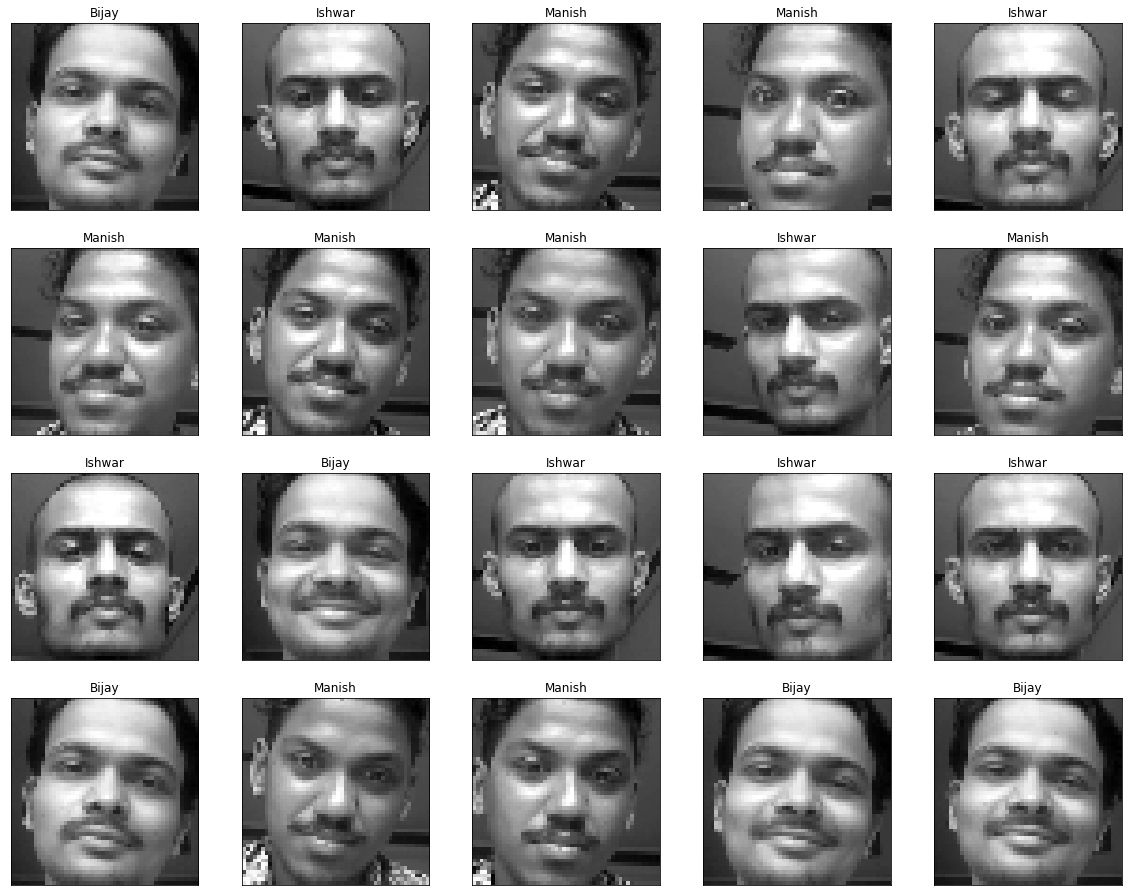

In [14]:
import matplotlib.pyplot as plt   # pip install matplotlib

fig = plt.figure(figsize=(20,20))
for num, data in enumerate(Vdata[:20]):
    img_data = data[0]
    y = fig.add_subplot(5,5, num+1)
    image = img_data
    data = img_data.reshape(50,50,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 0:
        my_label = 'Ishwar'
    elif np.argmax(model_out) == 1:
        my_label = 'Manish'
    else:
        my_label = 'Bijay'
        
    y.imshow(image, cmap='gray')
    plt.title(my_label)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()